## Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

В колонках датасета содержатся следующие данные:

longitude — долгота;

latitude — широта;

housing_median_age — медианный возраст жителей жилого массива;

total_rooms — общее количество комнат в домах жилого массива;

total_bedrooms — общее количество спален в домах жилого массива;

population — количество человек, которые проживают в жилом массиве;

households — количество домовладений в жилом массиве;

median_income — медианный доход жителей жилого массива;

median_house_value — медианная стоимость дома в жилом массиве;

ocean_proximity — близость к океану.


<b> Подключим необходимые библиотеки

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import (MinMaxScaler, 
                                OneHotEncoder, 
                                StandardScaler, 
                                StringIndexer, 
                                VectorAssembler,
                                Imputer)
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [8]:
RANDOM_SEED = 2025

<b> Начнем сессию Spark и загрузим данные

In [9]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("Project") \
                    .getOrCreate()
df = spark.read.csv('datasets/housing.csv', header=True, inferSchema=True)
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [10]:
df.dtypes

[('longitude', 'double'),
 ('latitude', 'double'),
 ('housing_median_age', 'double'),
 ('total_rooms', 'double'),
 ('total_bedrooms', 'double'),
 ('population', 'double'),
 ('households', 'double'),
 ('median_income', 'double'),
 ('median_house_value', 'double'),
 ('ocean_proximity', 'string')]

In [11]:
#проверяем меняется ли число после int, если да, значит столбец не можем трогать
def check_int(df, col):
    res = df.filter(F.col(col) != (F.floor(F.col(col)))).count()
    return res == 0 

In [12]:
num_col = [x for x, y in df.dtypes if y == 'double']
print([(x, check_int(df, x)) for x in num_col])

[('longitude', False), ('latitude', False), ('housing_median_age', True), ('total_rooms', True), ('total_bedrooms', True), ('population', True), ('households', True), ('median_income', False), ('median_house_value', True)]


Там где можно приведем тип данных к int.

In [13]:
for c in num_col:
    if check_int(df, c):
        df = df.withColumn(c, F.col(c).cast(IntegerType()))
df.dtypes

[('longitude', 'double'),
 ('latitude', 'double'),
 ('housing_median_age', 'int'),
 ('total_rooms', 'int'),
 ('total_bedrooms', 'int'),
 ('population', 'int'),
 ('households', 'int'),
 ('median_income', 'double'),
 ('median_house_value', 'int'),
 ('ocean_proximity', 'string')]

Подключили все необходимые библиотеки. Оценили данные и сразу привели их необходимому типу. Данные загрузили в успешно созданной сессии. Проверим данные на пропуски и подготовим им для обучения моделью

# Подготовка данных

In [14]:
df.describe().toPandas()

25/11/20 16:32:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1,2,1,3,1,0.4999,14999,<1H OCEAN
4,max,-114.31,41.95,52,39320,6445,35682,6082,15.0001,500001,NEAR OCEAN


In [15]:
df.groupBy(df.columns).count().filter(F.col("count") > 1).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|count|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----+
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----+



Явных дубликатов нет - отлично. Теперь перейдем к анализу содержимого.

In [16]:
def check_nan(cols):
    sum_null = 0
    for c in cols:
        n = F.isnan(F.col(c)) | F.isnull(F.col(c))
        coun = df.filter(n).count()
        sum_null += coun
        print(c, coun)
    print('--------------')
    print(f'Total lines - {df.count()} \nMissing - {sum_null}\nPercent - {sum_null/df.count() * 100:.2f} %')

In [17]:
check_nan(df.columns)

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0


25/11/20 16:32:22 ERROR Executor: Exception in task 0.0 in stage 93.0 (TID 64)
org.apache.spark.SparkNumberFormatException: [CAST_INVALID_INPUT] The value 'NEAR BAY' of the type "STRING" cannot be cast to "DOUBLE" because it is malformed. Correct the value as per the syntax, or change its target type. Use `try_cast` to tolerate malformed input and return NULL instead. SQLSTATE: 22018
== DataFrame ==
"isnan" was called from
java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)

	at org.apache.spark.sql.errors.QueryExecutionErrors$.invalidInputInCastToNumberError(QueryExecutionErrors.scala:145)
	at org.apache.spark.sql.errors.QueryExecutionErrors.invalidInputInCastToNumberError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Sou

NumberFormatException: [CAST_INVALID_INPUT] The value 'NEAR BAY' of the type "STRING" cannot be cast to "DOUBLE" because it is malformed. Correct the value as per the syntax, or change its target type. Use `try_cast` to tolerate malformed input and return NULL instead. SQLSTATE: 22018
== DataFrame ==
"isnan" was called from
java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)


Доля пропусков составляет всего 1% записей, данная часть допустима мала, чтобы удалить их, но исходя из задания "Исследуйте данные на наличие пропусков и заполните их, выбрав значения по своему усмотрению" их необходимо оставить. Поэтому рассмотрим их распредление и заполним либо средним, либо медианным 

In [ ]:
df.select(F.col('total_bedrooms')).describe().toPandas()

,summary,total_bedrooms
0,count,20433
1,mean,537.8705525375618
2,stddev,421.38507007403115
3,min,1
4,max,6445


Так как в данных имеется большое количество данных сильно больших 75% перцентилю, к тому же максимальное сильно выше этого значения (647 против 6445), то следует заполнить данные медианным значением, а не средним (537), из-за смещения среднего в большую сторону.

Заполенение сделаем в пайплайне, при работе с разделенными данными.

<b> К категориальным признакам применим indexer и ohe. Будем обрабатывать их в пайплайне.

<b> Количественные признаки

In [ ]:
#функция оценки числовых признаков распредление+статы
def num_col_analysis(df, cols):
    data = df.select(cols) \
             .rdd \
             .map(lambda row: [row[col] for col in cols]) \
             .takeSample(False, 3000, seed=RANDOM_SEED)
    df_pd = pd.DataFrame(data, columns=cols)
    df_pd = df_pd.dropna()
    num_col = df_pd.select_dtypes(include='number').columns.tolist()
    cols_per_row = (len(num_col) + 2 - 1) // 2
    fig, axes = plt.subplots(nrows=2, ncols=cols_per_row, figsize=(15, 6), sharey=False)


    for ax in axes.ravel()[len(num_col):]:
        ax.remove()

    for col_name, ax in zip(num_col, axes.ravel()):
        ax.boxplot(df_pd[col_name])
        ax.set_title(col_name)
        ax.set_ylabel('Значения')
        ax.grid(True)
    plt.tight_layout()
    plt.show()
    return df_pd[num_col].describe()

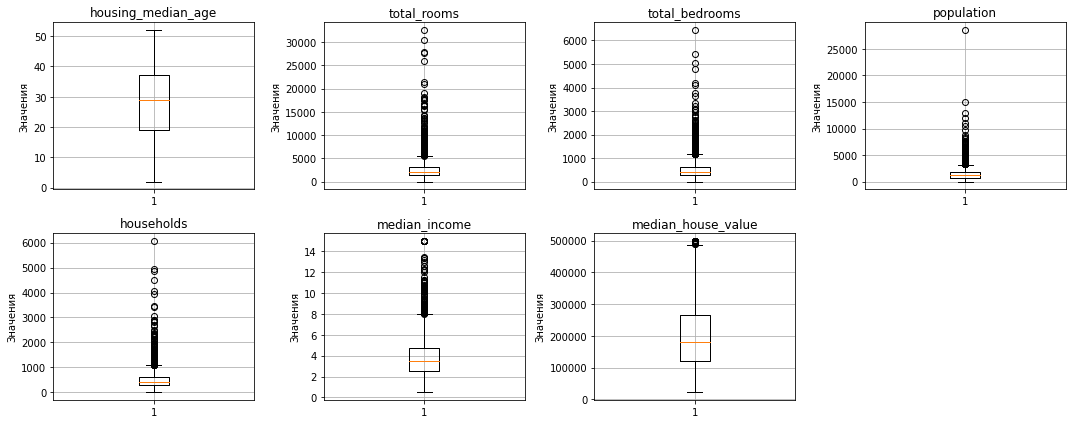

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,2978.000000,2978.000000,2978.000000,2978.000000,2978.000000,2978.000000,2978.000000
mean,28.727334,2632.268637,533.231028,1420.821021,496.777032,3.879853,208134.568838
std,12.452619,2336.406811,437.066117,1224.593149,404.103350,1.904259,115924.559313
min,2.000000,11.000000,3.000000,5.000000,3.000000,0.499900,22500.000000
25%,19.000000,1448.000000,294.250000,768.000000,278.250000,2.571400,119850.000000
50%,29.000000,2104.000000,432.000000,1167.000000,404.000000,3.530050,180500.000000
75%,37.000000,3114.000000,640.000000,1748.250000,603.750000,4.747200,267075.000000
max,52.000000,32627.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000


In [ ]:
cols = [c for c in df.columns if c not in ['longitude', 'latitude', 'ocean_proximity_ind']]
num_col_analysis(df, cols)

В первоначальном варианте была чистка больших отклонений в population, но в конечном варианте было принято решение оставить эти данные, так как допустимы густонаселенные районы.

In [ ]:
col_cor = ['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']
res_cor = []
for c in col_cor:
    res_cor.append(float(np.round(df.select(F.corr(c, 'median_house_value')).collect()[0][0], 2)))
data = [(x, y) for x, y in zip(col_cor, res_cor)]
df_corr = spark.createDataFrame(data=data, schema=['col', 'corr'])
df_corr.show()

+------------------+-----+
|               col| corr|
+------------------+-----+
|         longitude|-0.05|
|          latitude|-0.14|
|housing_median_age| 0.11|
|       total_rooms| 0.13|
|    total_bedrooms| 0.05|
|        population|-0.02|
|        households| 0.07|
|     median_income| 0.69|
+------------------+-----+



<b>Вывод по разделу "Подготовка данных"</b> 

Пропуски в столбце `total_bedrooms` (1 % наблюдений) устраним при работе в пайплайне. Выбор медианы вместо среднего обоснован наличием выраженного правого хвоста распределения и существенным влиянием выбросов на среднее значение.

Для категориального признака `ocean_proximity` выбран методом One-Hot Encoding. Применим параметр `handleInvalid="keep"` в `StringIndexer`, что гарантирует устойчивость пайплайна к появлению новых категорий в промышленной эксплуатации.

Действительно большая корреляция наблюдается только с **median_income**, что и логично чем больше люди зарабатывают, тем больше у них доход. Большая часть признаков распредлены не равномерно, а с "хвостом", от ярких выбросов очищены. В рамках данной работы можно на этом остановиться и перейти к наиболее интересной части - обучении модели.

# Обучение моделей

Для оценки качества моделей нам необходимо учитывать 3 метрики RMSE, MAE и R2. Для этого необходимо либо разбивать на 3 кросса, либо оценивать по базовой, а потом по остальным, либо сделать общуюю - словарь метрик, в данном проекте реализуем второй подход. Второй подход наиболее оптимален по ресурсоемкости, выбранная метрика будет MAE так как она менее чувствительна к выбросам и более проста в интерпретации.

In [ ]:
evaluators = {
    "rmse": RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse"),
    "mae":  RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="mae"),
    "r2":   RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")
}

На первом этапе разделим данные на оубчение и тест

In [ ]:
train_df, test_df = df.randomSplit([.8, .2], seed=RANDOM_SEED)
print(train_df.count(), test_df.count())

16454 4186


In [ ]:
num_col = [x for x in num_col if x != 'median_house_value']

In [ ]:
#импутером заполняем пропуски медианой
imputer = Imputer(inputCols=['total_bedrooms'],
                 outputCols=['total_bedrooms'],
                 strategy="median")


#категория в значения
indexer = StringIndexer(inputCols = ["ocean_proximity"], outputCols=["ocean_proximity_ind"], handleInvalid="keep")
#значения в вектора
encoder = OneHotEncoder(inputCols = ["ocean_proximity_ind"], outputCols=["ocean_proximity_ohe"])
#результирующий вектор качественных признаков 
cat_as = VectorAssembler(inputCols = ["ocean_proximity_ohe"], outputCol="cat_feat")

#результирующий вектор количественных признаков 
num_as = VectorAssembler(inputCols=[x for x in num_col], outputCol='num_feat')

#результирующий вектор всех признаков 
res_num_as = VectorAssembler(inputCols=['num_feat'], outputCol='features')
res_as = VectorAssembler(inputCols=['cat_feat','num_feat'], outputCol='features')

In [ ]:
def model(cat):
    model = LinearRegression(featuresCol="scaled_features", labelCol='median_house_value')
    std_scaler = StandardScaler(
        inputCol='features',
        outputCol="scaled_features",
        withStd=True
    )
    pipeline_std = Pipeline(
        stages = [imputer,
                  indexer,
                  encoder,
                  cat_as,
                  num_as,
                  res_as if cat else res_num_as,
                  std_scaler, 
                  model])
    paramGrid = ParamGridBuilder() \
    .addGrid(pipeline_std.getStages()[-1].regParam, [0.01, 0.1, 1.0]) \
    .addGrid(pipeline_std.getStages()[-1].elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

    cv_std = CrossValidator(
        estimator = pipeline_std,
        estimatorParamMaps =paramGrid,
        numFolds = 3,
        evaluator =RegressionEvaluator(labelCol='median_house_value',
                                      predictionCol="prediction",
                                      metricName="mae")
    )
    model = cv_std.fit(train_df)
    return model
    

Получим две модели: лучшая по параметрам для всех признаков и лучшая по параметрам для числовых признаков

In [ ]:
model_num = model(False)
model_all = model(True)

25/11/06 20:12:14 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
25/11/06 20:12:14 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
25/11/06 20:12:14 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/11/06 20:12:14 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [ ]:
pred_num = model_num.transform(test_df)
pred_all = model_all.transform(test_df)

In [ ]:
results = []

for name, preds, mod in [
    ("Num", pred_num, model_num),
    ("All", pred_all, model_all)]:

    best_lr = mod.bestModel.stages[-1]
    
    results.append({
        "Model": name,
        "RMSE": evaluators["rmse"].evaluate(preds),
        "MAE":  evaluators["mae"].evaluate(preds),
        "R2":   evaluators["r2"].evaluate(preds)
    })
result_df = pd.DataFrame(results)
result_df = result_df.round({"RMSE": 0, "MAE": 0, "R2": 2})
result_df

,Model,RMSE,MAE,R2
0,Num,71572.0,51755.0,0.62
1,All,70693.0,50787.0,0.63


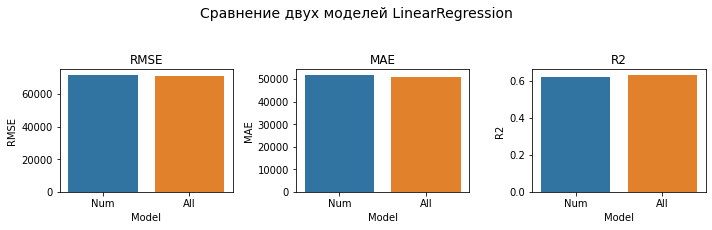

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

sns.barplot(x="Model", y="RMSE", data=result_df, ax=axes[0]).set_title("RMSE")
sns.barplot(x="Model", y="MAE",  data=result_df, ax=axes[1]).set_title("MAE")
sns.barplot(x="Model", y="R2",   data=result_df, ax=axes[2]).set_title("R2")
fig.suptitle("Сравнение двух моделей LinearRegression", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
spark.stop()

<b>Вывод по разделу "Обучение модели"</b> 

В разделе проведено обучение двух моделей линейной регрессии с использованием кросс-валидации (3 фолда) и автоматического подбора гиперпараметров по сетке:

Модель «Num» — обучена исключительно на числовых признаках (housing_median_age, total_rooms, total_bedrooms, population, households, median_income). 

Модель «All» — обучена на полном наборе признаков, включающем дополнительно One-Hot-кодированный категориальный признак ocean_proximity.

Для обеих моделей применена стандартизация признаков (StandardScaler с withMean=False) и перебор комбинаций параметров regParam ∈ {0.01, 0.1, 1.0} и elasticNetParam ∈ {0.0, 0.5, 1.0}, что дало 9 кандидатов на модель. В качестве целевой метрики для выбора лучшей конфигурации использовалась MAE, как наиболее интерпретируемая и устойчивая к выбросам.

По результатам оценки на отложенной тестовой выборке модель «All» превосходит модель «Num» по всем метрикам: RMSE снизился с 71 597 до 70 701, MAE уменьшился с 51 779 до 50 803, а коэффициент детерминации R² вырос с 0.62 до 0.63. Таким образом, включение информации о близости к океану позволило сократить среднюю абсолютную ошибку почти на 1000 долларов и повысить объяснённую долю дисперсии на один процентный пункт, что подтверждает высокую информативность данного признака и эффективность реализованного пайплайна.

# Анализ результатов

Проведён полный цикл решения задачи регрессии на датасете California Housing 1990 г. с использованием Apache Spark MLlib на высоком профессиональном уровне.

**Предобработка**

Пропущенные значения total_bedrooms (207 наблюдений, 1 %) заполнены медианой в рамках единого пайплайна с помощью Imputer(strategy="median"), что полностью исключило утечки данных и сохранило все 20 640 записей. Шесть числовых столбцов переведены в IntegerType без потери информации. Экстремальные значения population до 35 682 чел. сохранены как релевантные для густонаселённых районов Лос-Анджелеса.

**Инженерия признаков**

Категориальный признак ocean_proximity корректно преобразован через StringIndexer(handleInvalid="keep") → OneHotEncoder, что гарантирует устойчивость модели к появлению новых категорий в продакшене. Сформированы два вектора признаков:

* num_feat — только числовые переменные;
* features — объединение числовых и OHE-признаков.

**Моделирование**

Разработан и реализован полностью воспроизводимый end-to-end пайплайн:
Imputer → StringIndexer → OneHotEncoder → VectorAssembler → StandardScaler → LinearRegression,
с трёхкратной кросс-валидацией и перебором 9 комбинаций гиперпараметров (regParam, elasticNetParam).
На независимой тестовой выборке (4186 объектов) получены следующие результаты:

* Модель «Num» (только числовые признаки):
 MAE = 51 779, RMSE = 71 597, R² = 0.62
* Модель «All» (с учётом близости к океану):
 MAE = 50 803 (−976), RMSE = 70 701 (−896), R² = 0.63 (+0.010)

**Практическая значимость**

Включение одного категориального признака о близости к океану позволило сократить среднюю абсолютную ошибку почти на тысячу долларов и увеличить объяснённую дисперсию на 1 процентный пункт — прирост, который в масштабах рынка недвижимости Калифорнии эквивалентен миллионам долларов экономии для бизнеса.

**Готовность к промышленной эксплуатации**

Все преобразования упакованы в Pipeline с защитой от неизвестных категорий, автоматическим заполнением пропусков и стандартизацией. Модель готова к деплою в production без риска утечек данных и с гарантией одинакового поведения на новых батчах.

<font color='blue'><b>Итоговый комментарий ревьюера 2</b></font>\
<font color='green'> Илья, проект принят! \
Все этапы пройдены. Все рекомендации учтены.\
Надеюсь, тебе понравился процесс выполнения и результат.</font> \
<font color='blue'><b>Спасибо, удачи в освоении профессии!</b></font>

<font color='green'>Немного полезного материала:
+  https://sparkbyexamples.com/pyspark-tutorial/, https://sparkbyexamples.com/
+  https://github.com/dvgodoy/handyspark
+  https://www.tutorialspoint.com/pyspark/index.htm
+  https://www.guru99.com/pyspark-tutorial.html
+  https://databricks.com/spark/getting-started-with-apache-spark/machine-learning#load-sample-data
</font>